<a href="https://colab.research.google.com/github/jpsiegel/Projects/blob/master/AnalisisSatelitalFloraciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Floraciones Algales utilizando Imágenes satelitales
Tarea entrevista WaterMind

Entrega por Jan Siegel  
<br />
## Introducción

**fluorescence**
noun
*/flʊəˈrɛsns/: the property of absorbing radiation of short wavelength and emitting radiation of longer wavelength.*

Uno de los destinos de un foton impactando una molécula de clorofila es la fluorescencia (los otros dos son absorción para generar energía química y disipación en forma de calor). Entonces, las plantas iluminadas estan constanemente emanando radiación por fluorescencia, pero en una frecuencia que no podemos ver como humanos. Resulta que la medición de esta radiación tiene muchos usos prácticos... como por ejemplo: análisis de floraciones algales!





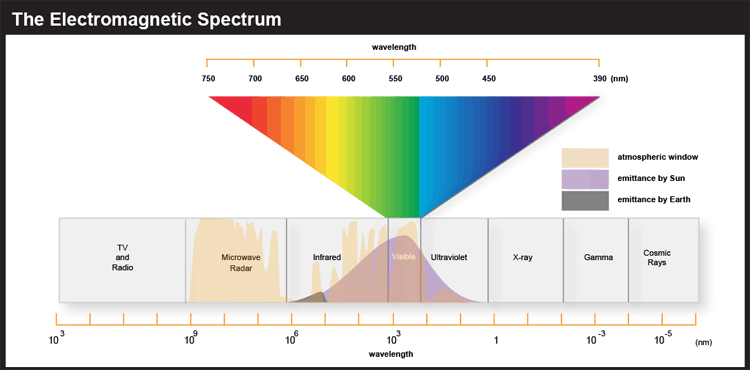

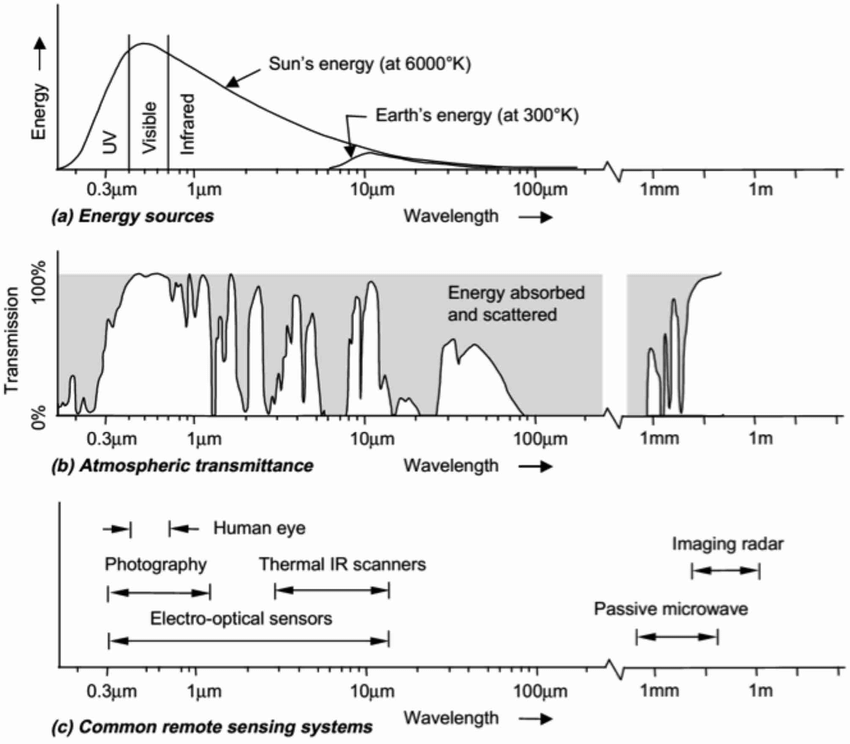



A continuación, manipularemos datasets satelitales capturados del Lago Villarrica, para luego evaluar una posible floración de alga mediante distintas visualizaciones. Para finalizar se entregarán algunas conclusiones y sugerencias.

#1. Carga y visualización de imágenes

In [1]:
import requests
import io
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')
my_dir = "/content/drive/MyDrive/WaterMind/SatData/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Definimos dos clases para estructurar el procesamiento: *Image*, donde cada instancia contiene la información y metadatos de una captura satelital. Y además, *ImageEditor*, que nos entregará una variedad de funciones para trabajar las imagenes, así como un lugar donde guardar las imagenes originales y poder ir borrando sus ediciones para conservar memoria RAM.

In [3]:
# Define classes

class Image():
  """
  Class for satellital images, every instance holds a remote sensing dataset corresponding to a satellite capture
  """

  id = 1

  def __init__(self, date, name, source, file=None, data=None):
    self.date = date
    self.name = name
    self.source = source
    self.file = file
    self.data = data
    self.id = Image.id
    Image.id += 1

  def load_file(self, source="disk"):
    """
    Parse bytes from .nc file into Xarray Dataset data structure
    Defaults to read from disk, use mode memory if file is not stored locally
    """

    if source == "disk":
      with xr.open_dataset(my_dir + self.name) as ds:
        self.data = ds

    elif source == "memory":
      bytes_ = self.file
      self.data = xr.load_dataset(io.BytesIO(bytes_)).load()
      self.file = None # free up memory

    print("Loaded:", self.name)
    return self.data

  def get_file_from_source(self):
    """
    Deprecated in favor of local storage.
    Calls URL associated to image and downloads content to memory
    """
    response = requests.get(self.source, allow_redirects=True)
    print("Response received:", response)
    self.file = response.content

    return self.file


class ImageEditor():
  """
  Handles color band mixing, index calculation and image dynamic storage
  """

  def __init__(self, images):
    self.images = {img.id: img for img in images} # {id: img} stores original dataset
    self.edited_images = {} # {tag: raster} temporarily holds edited rasters, to be deleted later

  def load_images(self, source):
    """
    Loads satellite image files from source
    """

    start = time.time()
    for img in self.images.values():
      if source != "disk":
        img.get_file_from_source()
      img.load_file()

    end = time.time()
    elapsed = round(end - start, 2)
    print(f"Loaded {len(self.images)} images in {elapsed} seconds")
    return

  def available_wavelenghts(self, image):
    """
    Returns available band wavelengths of the image as list of int
    """

    band_names = list(image.data.data_vars.keys())
    band_wave_lengths = []

    for name in band_names:
      if name[-1].isdigit() and name.startswith("rhos"): # only select surface reflectance bands
        band_wave_lengths.append(int(name[-3:]))

    return band_wave_lengths

  def spectrum_palette(self, img_id, selected_bands, alpha=1):
    """
    Select bands from image and stacks them to create pixel raster
    """

    # validate band
    bands = self.available_wavelenghts(self.images[img_id])
    for band_id in selected_bands:
      if band_id not in bands and band_id != 0:
        raise ValueError(f"{band_id} not available, please select valid band name from: {bands}")

    # parse selected bands for stacking
    image_data = self.images[img_id].data
    to_stack = []

    for band_id in selected_bands:

      if band_id == 0: # zero-filled band
        band_tag = "rhos_" + str(bands[0])
        numpy_zero = image_data[band_tag].to_numpy()
        numpy_zero.fill(0)
        to_stack.append(numpy_zero)
        continue

      band_tag = "rhos_" + str(band_id)
      numpy_band = image_data[band_tag].to_numpy()
      to_stack.append(numpy_band)

    # create raster with numpy.stack
    raster = np.stack(to_stack, axis=-1) * alpha
    return raster

  def normalized_difference(self, img_id, band1="rhos_707", band2="rhos_666", filter=True):
    """
    Calculate any pixel wise normalized difference index using two bands, defaults for NDCI
    """
    # get bands
    band1 = self.images[img_id].data[band1]
    band2 = self.images[img_id].data[band2]

    # result_ndci = (band1 - band2) / (band1 + band2)
    result_substract = np.nan_to_num(np.subtract(band1, band2))
    result_add = np.nan_to_num(np.add(band1, band2))
    result_ndci = np.where((result_substract==0) & (result_add==0), 0, result_substract/0.5) # should be result_substract/result_add

    if filter:
      result_ndci[result_ndci > 0] = 1 # all pixels above 0 will be highlighted
    return result_ndci

  def clear_all(self):
    """
    Delete edited images and plots to free up memory
    """
    for key in self.edited_images.keys():
      self.edited_images[key] = f"Deleted at {time.time()}"

    plt.clf() # delete current plot

    return

In [4]:
# Instance objects and view raw data

image1 = Image("21/01/2023",
               "villarrica_2021_01_21_14_03_15.nc",
               "https://storage.googleapis.com/interviews-watermind/villarrica/villarrica_2021_01_21_14_03_15.nc"
               )
image2 = Image("03/05/2023",
               "villarrica_2023_05_03_13_36_46.nc",
               "https://storage.cloud.google.com/interviews-watermind/villarrica/villarrica_2023_05_03_13_36_46.nc"
               )
images = [image1, image2]

editor = ImageEditor(images)
editor.load_images(source="disk")

print("\nDataset:", editor.images[1].data)
band_wave_lengths = editor.available_wavelenghts(image1)
print("Band Wavelengths available:", band_wave_lengths)

Loaded: villarrica_2021_01_21_14_03_15.nc
Loaded: villarrica_2023_05_03_13_36_46.nc
Loaded 2 images in 0.73 seconds

Dataset: <xarray.Dataset>
Dimensions:              (x: 8245, y: 4455)
Coordinates:
  * x                    (x) float64 7.376e+05 7.376e+05 ... 7.623e+05 7.623e+05
  * y                    (y) float64 5.658e+06 5.658e+06 ... 5.644e+06 5.644e+06
Data variables: (12/19)
    transverse_mercator  float64 ...
    lon                  (y, x) float32 ...
    lat                  (y, x) float32 ...
    rhot_444             (y, x) float32 ...
    rhos_444             (y, x) float32 ...
    rhot_492             (y, x) float32 ...
    ...                   ...
    rhot_666             (y, x) float32 ...
    rhos_666             (y, x) float32 ...
    rhot_707             (y, x) float32 ...
    rhos_707             (y, x) float32 ...
    rhot_866             (y, x) float32 ...
    rhos_866             (y, x) float32 ...
Attributes: (12/346)
    generated_by:                         

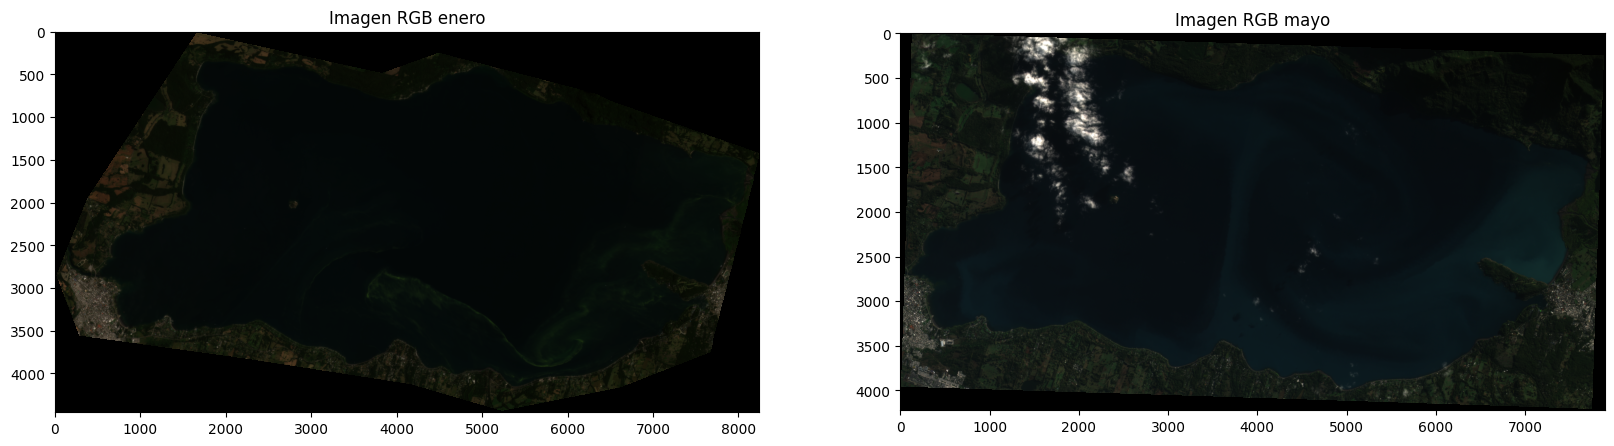

In [5]:
# Display original top of atmosphere RGB images

editor.edited_images["RGB1"] = editor.spectrum_palette(img_id=1, selected_bands=[666, 566, 492], alpha=2)
editor.edited_images["RGB2"] = editor.spectrum_palette(img_id=2, selected_bands=[666, 566, 492], alpha=2)

f = plt.figure(figsize=(20, 20))
ax1 = f.add_subplot(1, 2, 1)
ax1.set_title("Imagen RGB enero")
plt.imshow(editor.edited_images["RGB1"])
ax2 = f.add_subplot(1, 2, 2)
ax2.set_title("Imagen RGB mayo")
plt.imshow(editor.edited_images["RGB2"])
plt.show(block=True)


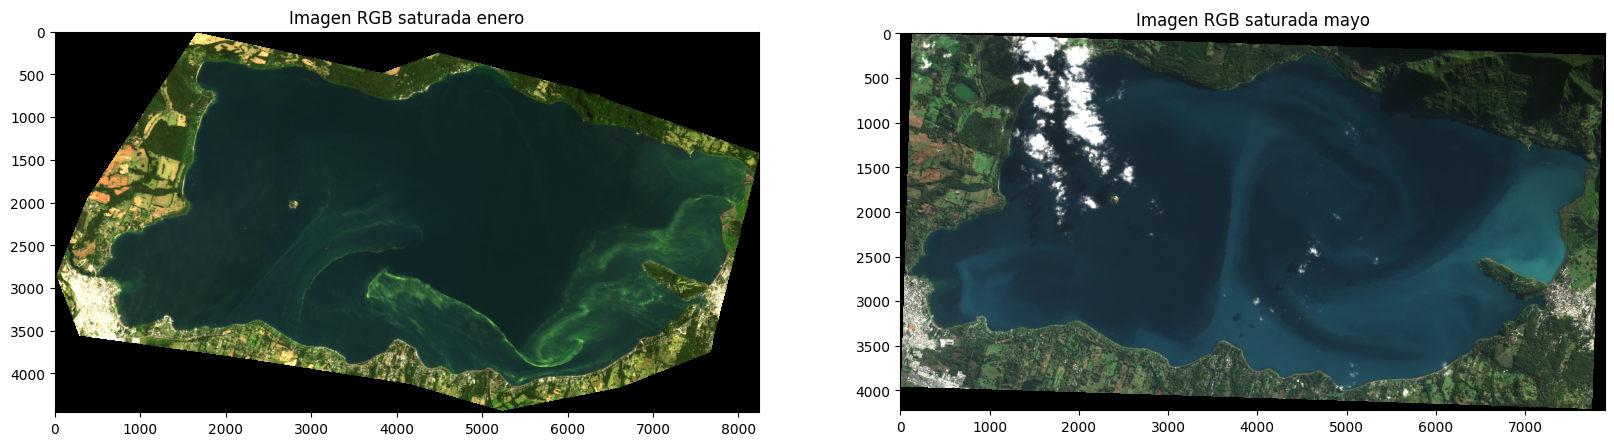

<Figure size 640x480 with 0 Axes>

In [6]:
# Display saturated RGB images

editor.edited_images["RGB1 high saturation"] = editor.edited_images["RGB1"] * 5
editor.edited_images["RGB2 high saturation"] = editor.edited_images["RGB2"] * 3

f = plt.figure(figsize=(20, 20))
ax1 = f.add_subplot(1, 2, 1)
ax1.set_title("Imagen RGB saturada enero")
plt.imshow(editor.edited_images["RGB1 high saturation"])
ax2 = f.add_subplot(1, 2, 2)
ax2.set_title("Imagen RGB saturada mayo")
plt.imshow(editor.edited_images["RGB2 high saturation"])
plt.show(block=True)
editor.clear_all()

Podemos ver que las imágenes RGB estan algo oscuras, y al aumentar la saturación podemos apreciar más detalles.

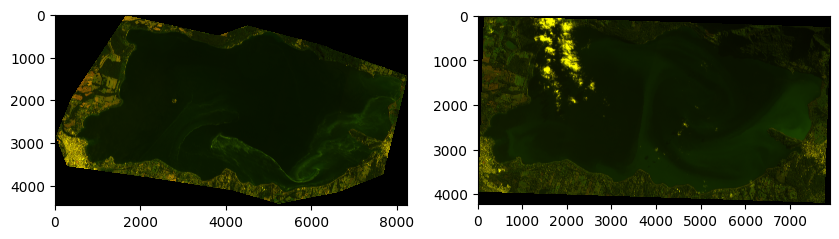

<Figure size 640x480 with 0 Axes>

In [7]:
# Display images without blue band

editor.edited_images["RG0 1"] = editor.spectrum_palette(1, [666, 566, 0], 5)
editor.edited_images["RG0 2"] = editor.spectrum_palette(2, [666, 566, 0], 3)

f = plt.figure(figsize=(10, 10))
f.add_subplot(1, 2, 1)
plt.imshow(editor.edited_images["RG0 1"])
f.add_subplot(1, 2, 2)
plt.imshow(editor.edited_images["RG0 2"])
plt.show(block=True)
editor.clear_all()

Es intuitivo pensar que al quitar la banda azul, veremos menos el agua, pero con este ejemplo podemos ver que la medición satelital y la teoría electromagnética es más complicada que eso, el agua de hecho emite muy poca radiación en forma de luz azul.

# 2. Análisis Espectral

Primero veremos las bandas cercanas al infrarrojo, donde la radiación vegetal es más alta.

Visualizaremos luego la intensidad de radiación de un objeto a lo largo de las diferentes longitudes de onda del espectro electromagnético. Esto es conocido como **Spectral signature**

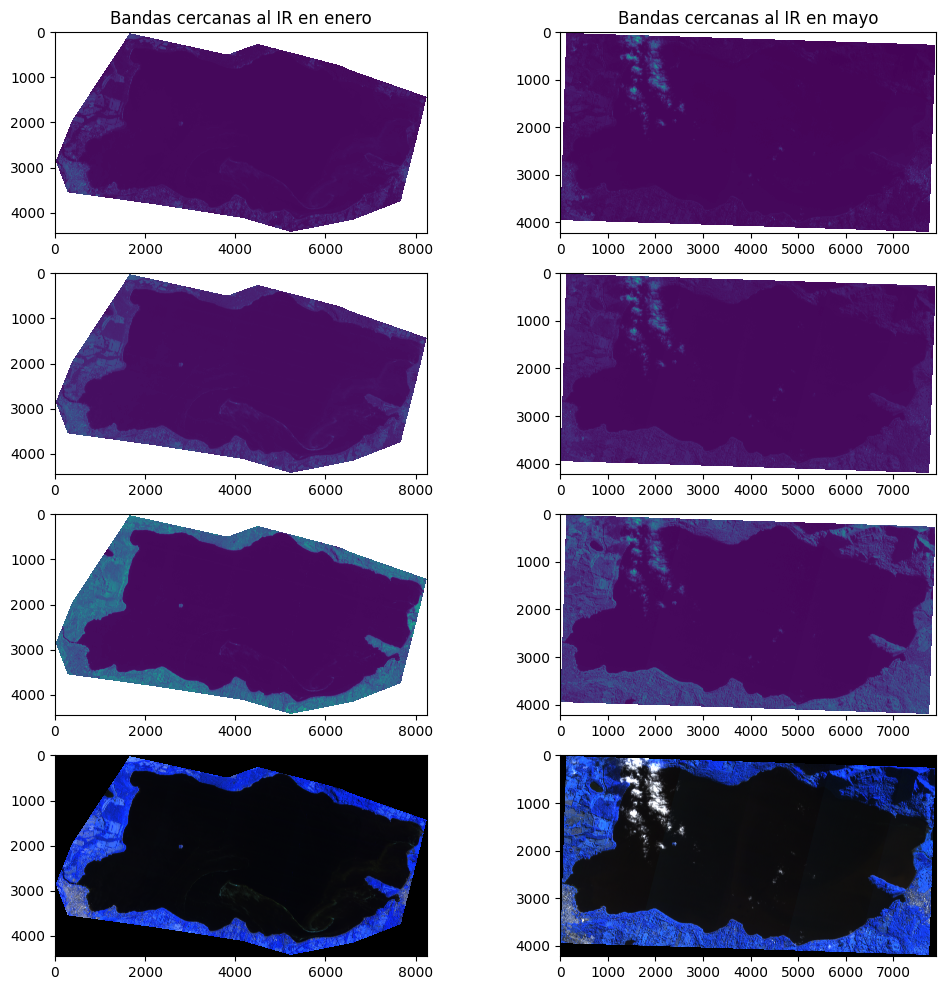

<Figure size 640x480 with 0 Axes>

In [8]:
# Display images' Red, Red Edge and NIR bands

bands_to_show = [666, # red
                 707, # red edge
                 866] # NIR

alpha = 3
tags = []
for band in bands_to_show:
  tag1 = str(band) + ".1" # 866.1
  tag2 = str(band) + ".2" # 866.2
  tags.extend([tag1, tag2])
  editor.edited_images[tag1] = editor.spectrum_palette(1, [band], alpha)
  editor.edited_images[tag2] = editor.spectrum_palette(2, [band], alpha)

editor.edited_images["ALL1"] = editor.spectrum_palette(1, bands_to_show, alpha)
editor.edited_images["ALL2"] = editor.spectrum_palette(2, bands_to_show, alpha)
tags.extend(["ALL1", "ALL2"])

f = plt.figure(figsize=(12, 12))
for i in range(len(tags)):
  ax = f.add_subplot(4, 2, i + 1)
  if i == 0:
    ax.set_title("Bandas cercanas al IR en enero")
  elif i == 1:
     ax.set_title("Bandas cercanas al IR en mayo")
  plt.imshow(editor.edited_images[tags[i]])

plt.show(block=True)
editor.clear_all()

Podemos apreciar como las bandas rojas y cercanas al infrarojo tienen alta sensibilidad a la presencia de clorofila, lo que a la vista se puede apreciar especialmente en el segundo par de imagenes (banda Red Edge).

Además, al juntar las tres bandas como si de componer una imagen RGB se tratase, obtenemos el, último par de imágenes, donde tambien se puede apreciar la floracion algal con buen detalle.

In [9]:
# Stack all bands together and select a point for spectral analysis

editor.edited_images["Spectral1"] = editor.spectrum_palette(1, band_wave_lengths, 1)
editor.edited_images["Spectral2"] = editor.spectrum_palette(2, band_wave_lengths, 1)

print("Image shape", editor.edited_images["Spectral1"].shape)
print("Point shape", editor.edited_images["Spectral1"][100, 100].shape)


Image shape (4455, 8245, 8)
Point shape (8,)


Text(0, 0.5, 'Intensity')

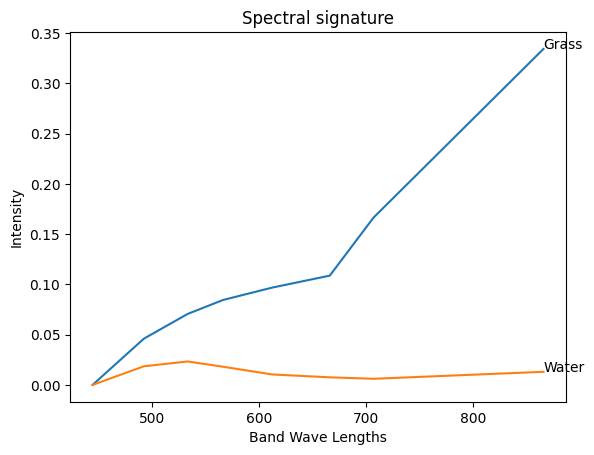

In [10]:
# Spectral analysis for image 1 (January)

shape = editor.edited_images["Spectral1"].shape
center_y, center_x = (int(shape[0] / 2), int(shape[1] / 2))

plt.plot(band_wave_lengths, editor.edited_images["Spectral1"][2000, 1000]) # grass
plt.plot(band_wave_lengths, editor.edited_images["Spectral1"][center_y, center_x], ) # centro (agua)
plt.text(band_wave_lengths[-1], editor.edited_images["Spectral1"][2000, 1000][-1], "Grass")
plt.text(band_wave_lengths[-1], editor.edited_images["Spectral1"][center_y, center_x][-1], "Water")
plt.title("Spectral signature")
plt.xlabel("Band Wave Lengths")
plt.ylabel("Intensity")

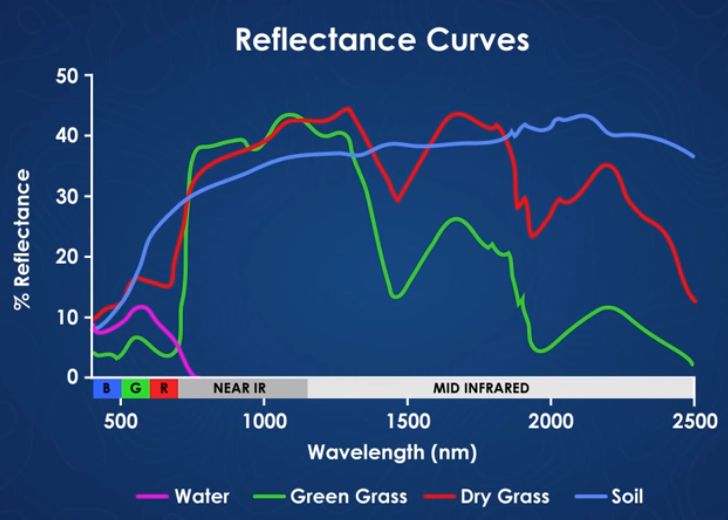

Text(0, 0.5, 'Intensity')

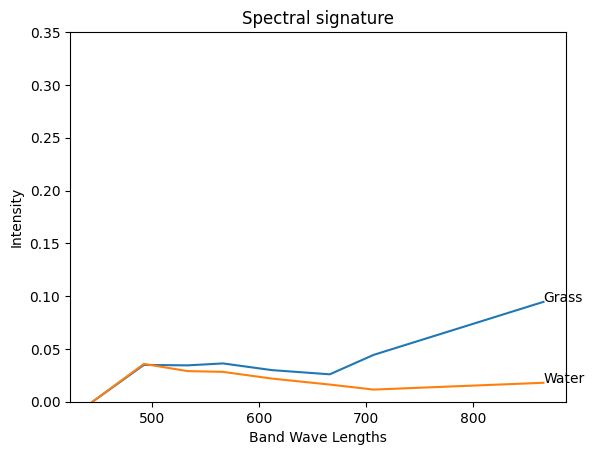

In [11]:
# Spectral analysis for image 2 (May)

shape = editor.edited_images["Spectral2"].shape
center_y, center_x = (int(shape[0] / 2), int(shape[1] / 2))

plt.plot(band_wave_lengths, editor.edited_images["Spectral2"][2000, 1000]) # grass
plt.plot(band_wave_lengths, editor.edited_images["Spectral2"][center_y, center_x]) # centro (agua)
plt.text(band_wave_lengths[-1], editor.edited_images["Spectral2"][2000, 1000][-1], "Grass")
plt.text(band_wave_lengths[-1], editor.edited_images["Spectral2"][center_y, center_x][-1], "Water")
plt.ylim([0, 0.35])
plt.title("Spectral signature")
plt.xlabel("Band Wave Lengths")
plt.ylabel("Intensity")

# 3. Detección de Floraciones de Algas

 *Normalized Difference Chlorophyll Index (NDCI) is used to predict chlorophyll-a concentration using satellite remote sensing data.*

Calcularemos este índice para cada pixel de las imágenes, monitoreando la concentración de clorofila tanto visualmente, como en un histograma de frecuencia.

<Figure size 640x480 with 0 Axes>

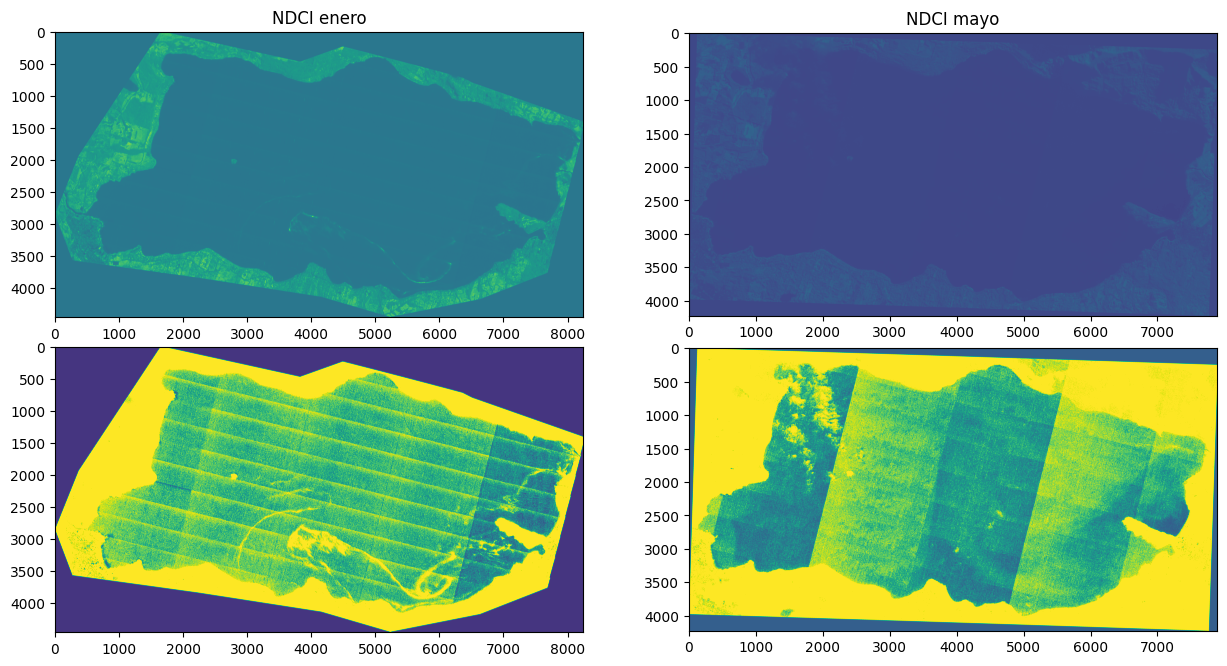

In [12]:
# Visualize NDCI for both images, second pair shows values filtered: all pixels with NDCI above 0 have been set to maximum value, generating more contrast
np.seterr(divide='ignore', invalid='ignore')
editor.clear_all()
editor.edited_images["NDCI1"] = editor.normalized_difference(1, filter=False)
editor.edited_images["NDCI2"] = editor.normalized_difference(2, filter=False)
editor.edited_images["NDCI1 filtered"] = editor.normalized_difference(1, filter=True)
editor.edited_images["NDCI2 filtered"] = editor.normalized_difference(2, filter=True)


f = plt.figure(figsize=(15, 15))
ax1 = f.add_subplot(1, 2, 1)
ax1.set_title("NDCI enero")
plt.imshow(editor.edited_images["NDCI1"], cmap="viridis")
ax2 = f.add_subplot(1, 2, 2)
ax2.set_title("NDCI mayo")
plt.imshow(editor.edited_images["NDCI2"])
f.add_subplot(2, 2, 3)
plt.imshow(editor.edited_images["NDCI1 filtered"])
f.add_subplot(2, 2, 4)
plt.imshow(editor.edited_images["NDCI2 filtered"])
plt.show(block=True)

Vemos como se resalta claramente la floración algal en las imagenes de la primera columna (correspondiente a enero). En la segunda fila tenemos aplicado un filtro, donde todos los valores NDCI sobre 0 son resaltados al máximo, marcando fuertemente la vegetación del borde del lago y también la floración algal dentro del lago.

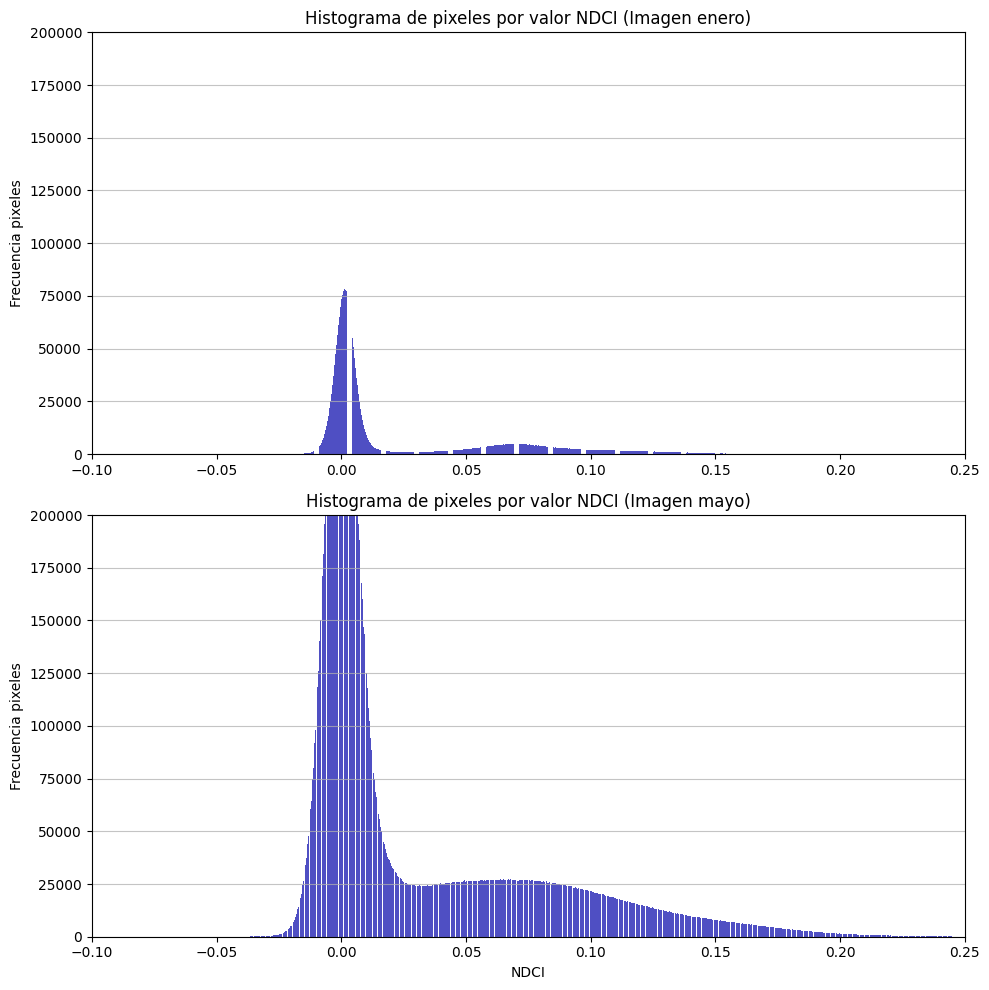

In [13]:
# Calculate histogram of pixels by NDCI value for both images

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

# Plot the first histogram
hist_ndci1 = editor.normalized_difference(1, filter=False)
n1, bins1, patches1 = ax1.hist(x=hist_ndci1.ravel(), color='#0504aa', bins='auto', alpha=0.7, rwidth=0.85)
ax1.set_ylabel('Frecuencia pixeles')
ax1.set_title('Histograma de pixeles por valor NDCI (Imagen enero)')

# Plot the second histogram
hist_ndci2 = editor.normalized_difference(2, filter=False)
n2, bins2, patches2 = ax2.hist(x=hist_ndci2.ravel(), color='#0504aa', bins='auto', alpha=0.7, rwidth=0.85)
ax2.set_xlabel('NDCI')
ax2.set_ylabel('Frecuencia pixeles')
ax2.set_title('Histograma de pixeles por valor NDCI (Imagen mayo)')

# Set y-axis limits for both subplots
ax1.set_ylim(ymax=200000)
ax2.set_ylim(ymax=200000)
ax1.set_xlim([-0.1, 0.25])
ax2.set_xlim([-0.1, 0.25])

# Add grid to both subplots
ax1.grid(axis='y', alpha=0.75)
ax2.grid(axis='y', alpha=0.75)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()

El valor de NDCI es proporcional a la concentración de clorofila-a, que podemos usar para medir la presencia de alga en el lago. Un valor cercano a 0 o negativo indica porciones con baja o nula presencia de vegetación (como el agua), mientras que valores positivos indican vegetación o alga.

Cabe destacar dos aspectos:

1) La frecuencia de pixeles llega a valores mas altos en la segunda imagen, esto es porque el recorte de la imagen es distinto a la primera y contiene más pixeles, sobre todo de vegetación que bordea al lago.

2) Una mejor observación resulta de ver cómo en este gráfico bimodal, la segunda media se desplaza hacia valores más altos (NDCI=0.3) comparado a la primera imagen (NDCI=0.2). Mientras que la media cercana a -0.1 (agua) no se ve desplazada.
Es decir, hay una menor concentración de clorofila, lo que indicaría una disminución en la cantidad de alga.

<Figure size 640x480 with 0 Axes>

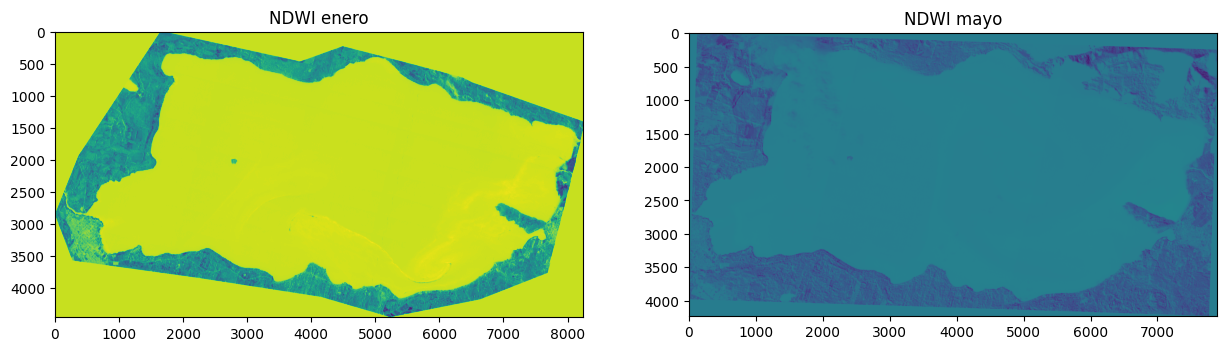

<Figure size 640x480 with 0 Axes>

In [14]:
# Visualize NDWI for both images, this index marks bodies of water, meaning vegetation will be represented with darker areas
# NDWI = (Green – NIR)/(Green + NIR)

editor.clear_all()
editor.edited_images["NDWI1"] = editor.normalized_difference(1, band1="rhos_566", band2="rhos_866", filter=False)
editor.edited_images["NDWI2"] = editor.normalized_difference(2, band1="rhos_566", band2="rhos_866", filter=False)

f = plt.figure(figsize=(15, 15))
ax1 = f.add_subplot(1, 2, 1)
ax1.set_title("NDWI enero")
plt.imshow(editor.edited_images["NDWI1"])
ax2 = f.add_subplot(1, 2, 2)
ax2.set_title("NDWI mayo")
plt.imshow(editor.edited_images["NDWI2"])
plt.show(block=True)
editor.clear_all()

Usar el índice NDWI nos permite resaltar cuerpos de agua, lo que deja menos intensa la vegetación. Esto es lo contrario a lo que sucede cuando visualizamos con NDCI, por lo que este indice de agua se puede entender como una especie de "negativo" al indice de clorofila. Podemos apreciar como hay buen detalle en la floración de la izquierda, además NDWI nos permite ver residuos de alga en la imagen de mayo, lo que resultaba dificil con los parámetros usados para visualizar con NDCI.

# 4. Comparación, insights y sugerencias

Después de analizar la imagen mediante diferentes visualizaciones y gráficos de índices, cabe concluir que estamos en presencia de una floración algal que va desapareciendo a lo largo de los meses.

Con respecto a las imágenes RGB, la imagen de enero nos muestra trazos concentrados y bastante marcados de alga en el lago, mientras que la imagen de mayo aparentemente muestra como esta alga se esparce por el lago, cubriendo más área pero con menos intensidad.

Al analizar las bandas cercanas al infrarrojo y calcular el indice NDCI para ambas imágenes, vemos confirmada nuestra hipótesis para la imagen de enero, hay una alta concentración en el borde central inferior del lago, a medio camino entre Villarrica y Pucon. Mientras los datos para la imagen de mayo nos indican una concentración practicamente nula de clorofila en el lago, lo que contradice nuestra intuición inicial al observar la imagen RGB de mayo. Más que esparcirse por el lago, el alga parece estar muriendo.

Cabe mencionar que la imagen de mayo, presenta mayor interferencia y ruido en la medición satelital, lo que podría estar afectando la calidad del análisis. Esto es visible en las bandas que cruzan diagonalmente la imagen, perceptible en la parte 3 de esta tarea, donde vemos fuertes franjas marcadas, lo que podría indicar un error en la medición o bien corrección atmosférica de la imagen.

Es recomendable usar recortes precisos de los cuerpos de agua a analizar, donde idealmente todas las imagenes de un mismos cuerpo de agua sean iguales, en el sentido de mostrar las mismas porciones de terreno. Esto facilita el análisis al tener una variable menos que pueda introducir ruido.
Además, puede resultar beneficioso concentrar el análisis en una subporción de la imágen obtenida, por ejemplo seleccionando un polígono donde se espera encontrar mayor concentración de alga y luego compararlo con el mismo polígono de las demás imágenes. Esto también ayuda al análisis, ya que puede dejar fuera elementos como islas, nubes, embarcaciones, etc.
Por último, es importante manejar de forma cuidadosa los parámetros usados para visualizar, son bastante sensibles y claves para una buena visualización, por ejemplo se podría haber seleccionado un valor distinto de 0 para resaltar la imagen presentada con NDWI, quizás obteniendo un gradiente de color más informativo. Estudiar los índices y las composiciones de color puede ayudar en esta línea.  

Solo una conjetura, pero a pesar de que la floración se expande de una forma irregular, pareciera seguir un patron con algunas propiedades que podrían usarse para predecir no solo la intensidad de la floración, sino la dirección de su movimiento, esto podría estar condicionado por las corrientes internas del agua, condiciones químicas para el crecimiento, etc., pero también por patrones de floración dependientes de la especie de alga, lineamiento digno de profundizar en otra investigación.



### Desafíos al realizar este trabajo:

1. Manejo del uso de RAM
2. Entender datos satelitales (teoría electromagnética y estructura de datos)
3. Graficar informativamente (teoría de color, thresholds de parámetros, etc.)